#Quantify Extragalactic Contamination in PySM3 Dust Intensity Maps

###Download the PySM Software and Navigate into the Directory `pysm`

In [1]:
!git clone https://github.com/galsci/pysm
!pip install pysm
!pip install healpy
%cd pysm

Cloning into 'pysm'...
remote: Enumerating objects: 4668, done.
remote: Counting objects: 100% (1682/1682), done.
remote: Compressing objects: 100% (450/450), done.
remote: Total 4668 (delta 1260), reused 1565 (delta 1216), pack-reused 2986
Receiving objects: 100% (4668/4668), 32.50 MiB | 14.36 MiB/s, done.
Resolving deltas: 100% (3271/3271), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 23.3 MB/s eta 0:00:00
/content/pysm


###Import the PySM3 Modules

In [2]:
import pysm3
from pysm3 import units as u
from pysm3.models.dust import blackbody_ratio

###Import helper modules
>Healpy: used for interacting with FITS files and working with map data in the Healpix format.

>Numpy: used for array arithmetic and numerical computations.

>Pandas: used for .csv file reading/writing.

> MatPlotLib: used for generating plots and graphs to evaluate the results of computation.

> Tqdm: used for tracking progress in loops or tasks.

In [3]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

###Dust Map Parameters
> `nside`: The resolution parameter determining the number of pixels in the dust map. Higher Nside values result in finer resolution but require more computational resources.

>`freq`: The frequency in GHz at which the dust intensity map emissions are observed. The dust emission characteristics can vary at different frequencies, so specifying the frequency helps in visualizing the emission properties of dust at a specific wavelength.


In [4]:
nside = 2048
freq = 343 * u.GHz

###Generate the Dust Intensity Maps from the Dust Models
### $E_{B-V}$

This section generates dust inensity maps based on models `d1`, `d9`, `d10`, `d11`, `d12`.

>`d1`: Thermal dust modeled as a modified black body (mbb) using Planck data at 545 GHz (intensity) and 353 GHz (polarization) with spatially varying temperature and spectral index. Assumes the same spectral index for polarization and intensity.

>`d9`: Simplified version of d10 with fixed spectral index (1.48) and fixed dust temperature (19.6 K) based on Planck 2018 results.

>`d10`: Single-component modified black body model using GNILC-based templates from Planck data, with reduced contamination from CIB and point sources. Includes added small-scale fluctuations using the logpoltens formalism.

>`d11`: Similar to d10 but generates stochastic small scales on-the-fly, offering flexibility in reproducing d10 with specific seeds and resolutions.

>`d12`: 3D model of polarized dust emission with six layers (MKD) based on "A 3-D model of polarised dust emission in the Milky Way" by Jacques Delabrouille, using different templates, spectral index, and dust temperature for each layer.

More information on these models is available [in the PySM3 Doc]( https://pysm3.readthedocs.io/en/latest/models.html#dust)

The units of these maps are microkelvin in Rayleigh-Jeans temperature units.

In [5]:
dust_models = ['d1','d9','d10','d11','d12']
dust_i_maps = []
for i in tqdm(range(len(dust_models))):
    config = pysm3.sky.PRESET_MODELS[dust_models[i]].copy()
    del config['class']
    if dust_models[i] == 'd11':
      sky_model = pysm3.models.ModifiedBlackBodyRealization(nside=nside, **config)
    elif dust_models[i] == 'd12':
      sky_model = pysm3.models.ModifiedBlackBodyLayers(nside=nside, **config)
    else:
      sky_model = pysm3.models.ModifiedBlackBody(nside=nside, **config)
    dust_i_maps.append(sky_model.get_emission(freq)[0])

 60%|██████    | 3/5 [02:12<01:31, 45.51s/it]/usr/local/lib/python3.10/dist-packages/healpy/fitsfunc.py:643: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.real[i] = almr
/usr/local/lib/python3.10/dist-packages/healpy/fitsfunc.py:644: ComplexWarning: Casting complex values to real discards the imaginary part
  alm.imag[i] = almi
/usr/local/lib/python3.10/dist-packages/healpy/sphtfunc.py:607: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asarray(cl, dtype=np.float64) if cl is not None else None)
/usr/local/lib/python3.10/dist-packages/healpy/sphtfunc.py:563: ComplexWarning: Casting complex values to real discards the imaginary part
  cls_list = [np.asarray(cls, dtype=np.float64)]
100%|██████████| 5/5 [14:01<00:00, 168.30s/it]


###Get locations of known galaxies

The data file `GLADE+_2048.csv` contains data on over 22 million known galaxies and quasars sourced from the [GLADE+ catalog](https://glade.elte.hu/). Each entry in the file includes the following details:

>`Pix`: The pixel location of the celestial object represented by a healpy map with an nside value of 2048. This location is derived from the `RA` (Right Ascension) and `Dec` (Declination) variables in the original dataset.

>`Z_bin`: The "bucket" to which the celestial body is assigned based on the redshift bins created using the [Tomographer interactive tool](http://tomographer.org/guest/jobs#). These bins help categorize galaxies based on their redshift values.

This comprehensive dataset has been reduced from a 40-column table to the essential data needed to perform our analysis.

In [6]:
galaxy_data = pd.read_csv('/content/GLADE+_2048.csv')
pixels = galaxy_data.Pix
z_bin_i = galaxy_data.Z_Bin

###Assign cut-offs for redshift buckets

These redshift bin cutoffs are based on the redshift bins in the Tomographer interactive tool. Each bin represents a particular interval of redshift values, allowing for efficient categorization and analysis of astronomical data according to their cosmic distances from Earth.

In [7]:
cutoffs = pd.read_csv('/content/z_bin_cutoffs.csv')
z_bins = cutoffs['z_bins']

###Estimating the Sky Average of the Reddening Field
### $<E_{B-V}>$

The code aims to estimate the spatial average of dust intensity maps, specifically to subtract Galactic contributions and quantify extragalactic contamination in the models. The original approach involved a slow and computationally intensive pixel-wise comparison of each pixel with the average intensity of its neighboring pixels within a square degree. To improve efficiency, the code now utilizes the `hp.sphtfunc.smoothing()` function, applying a Gaussian beam to smooth the maps. This process provides an approximate average intensity of neighboring pixels within a specified fwhm (full-width half-maximum) radius of 1°, reducing computational complexity while obtaining a usable estimation of the sky average for a region.

These units of these maps are the same units of the original dust intensity maps (microkelvin in Rayleigh-Jeans temperature units).

In [8]:
smooth_dust_maps = dust_i_maps.copy()
for i in tqdm(range(len(smooth_dust_maps))):
  smooth_dust_maps[i] = hp.sphtfunc.smoothing(smooth_dust_maps[i],fwhm=0.0174533)

100%|██████████| 5/5 [05:26<00:00, 65.25s/it]


### Generating Galaxy Maps for Different Redshift Bins

The provided code is designed to generate galaxy maps by utilizing histograms to group galaxies based on their pixel locations. The resulting maps showcase the distribution of galaxies in each pixel location, effectively representing the galaxy density in different regions. These maps are organized into distinct redshift bins, allowing us to accurately assess the expected excess light from galaxies falling within each specific range of redshift values.

In [9]:
z_maps = []
npixels = 12*nside**2
n_zbins = len(z_bins)
bins = np.arange(npixels + 1)

for i in tqdm(range(n_zbins)):
  pix_for_zbin_i_gal = pixels[z_bin_i == i]
  galaxy_map, bin_edges = np.histogram(pix_for_zbin_i_gal, bins=bins)
  z_maps.append(galaxy_map)

100%|██████████| 26/26 [05:49<00:00, 13.43s/it]


###Generating Expectation Galaxy Maps

The provided code is designed to represent the effective excess reddening around the reference for a given pixel based on the galaxy density in a region with `fwhm=22'` (equal to 0.0064 radians).

In [10]:
smooth_z_maps = z_maps.copy()
for i in tqdm(range(len(smooth_z_maps))):
  smooth_z_maps[i] = hp.sphtfunc.smoothing(smooth_z_maps[i],fwhm=0.0063995)

100%|██████████| 26/26 [24:26<00:00, 56.41s/it]


###Writing Expectation Galaxy Maps to File

The program offers the option to write the expectation galaxy maps to a file. Unlike the dust maps that use stochastic small scales generated at runtime, the galaxy data remains static. By writing the smoothed galaxy maps to a file, you can reuse them later, thereby offsetting the computational load of the program. If you plan on re-running the notebook against new dust models or dust models generated at different frequencies, I suggest saving the smoothed galaxy maps for faster processing and to avoid redundant computations in future analyses.

In [11]:
%mkdir z_maps
for i in tqdm(range(len(smooth_z_maps))):
  hp.write_map('z_maps/smooth_z_map' + str(i) + '.fits', smooth_z_maps[i])

100%|██████████| 26/26 [00:40<00:00,  1.54s/it]


###Generate Naive Galactic Mask

The code creates a naive mask to focus our analysis on a region with Galactic latitudes above |±30°| (absolute value of 30 degrees). By excluding pixels outside this latitude range, the analysis omits the central disc of our Galactic plane, which is densely populated with intergalactic celestial objects. This targeted approach allows us to examine only specific regions of interest while minimizing biases and reducing excessive noise from within our Galaxy.

In [12]:
# pixel index of every pixel in your map
pixindx = np.arange(12*nside**2)

# get array of (l, b) Galactic longitude and latitude values for every pixel
l_pix, b_pix = hp.pix2ang(nside, pixindx, lonlat=True)

# set everything below an absolute value of the Galactic latitude 30 degrees to 0 in a mask
mask_pixels = pixindx[np.abs(b_pix) < 30.]
good_pixels = pixindx[np.abs(b_pix) > 30.]

###Evaluate the Fluctuations of the Reddening Field
### $δ E_{B-V}(\phi) = E_{B-V} - <E_{B-V}>$

To evaluate the fluctuations of the reddening field (dust intensity map), we perform the subtraction of the sky average that was calculated earlier. The purpose of this step is to eliminate the intergalactic contributions, which may obscure the extragalactic signals present in our dust intensity maps. By removing the average contribution from the sky, we can focus on studying the specific variations or fluctuations in the dust intensity that originate from regions of interest within our galaxy or beyond.

In [13]:
corr_red = []

for i in tqdm(range(len(dust_i_maps))):
	val = dust_i_maps[i].value - smooth_dust_maps[i]
	corr_red.append(val[good_pixels])

100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


###Calculate the Fractional Overdensity Field
### $δ_r (φ, z) = \frac{N}{<N> - 1}$

The purpose of this code is to generate the fractional overdensity field for the galaxy maps corresponding to each redshift bin. This correlation represents a comparison between the expected number of galaxies and the actual number of galaxies observed at each location within the redshift bin. This information helps us evaluate the spatial distribution of galaxies and understand their clustering behavior.

In [14]:
corr_bins = []
ones_arr = np.ones(len(good_pixels))

for i in tqdm(range(n_zbins)):
	exp_galaxy_count = np.subtract(smooth_z_maps[i][good_pixels],ones_arr)
	act_galaxy_count = z_maps[i][good_pixels]
	corr_bins.append(np.divide(act_galaxy_count,exp_galaxy_count))

100%|██████████| 26/26 [00:09<00:00,  2.61it/s]


###Cross-correlate Dust Maps with Reference Galaxies

In the final step of the computation, we investigate the excess reddening observed in the dust intensity maps around regions known to contain galaxies. By cross-correlating the signals from our dust intensity maps with our reference galaxies, we quantify the extent of extragalactic "contamination" present in our models. Identifying systematic spikes in emissions around known galaxies and galaxy clusters allows us to discern that these emissions originate from sources outside our galaxy, serving as indicators of extragalactic contaminants.

In [15]:
corr_data = []

for i in tqdm(range(len(dust_models))):
	corr_data.append([])

for i in tqdm(range(len(dust_i_maps))):
	for j in range(len(corr_bins)):
		corr_data[i].append(int(np.correlate(corr_bins[j],corr_red[i])))

100%|██████████| 5/5 [00:00<00:00,  6.26it/s]


###Write the Results to a File

This optional step allows you to write the results of the computation to a file of comma separated values.

In [16]:
df = pd.DataFrame()
df['z_bins'] = z_bins

for i in tqdm(range(len(dust_models))):
	df[dust_models[i]] = corr_data[i]

df.to_csv('extragalactic_contamination.csv')

100%|██████████| 5/5 [00:00<00:00, 1940.55it/s]


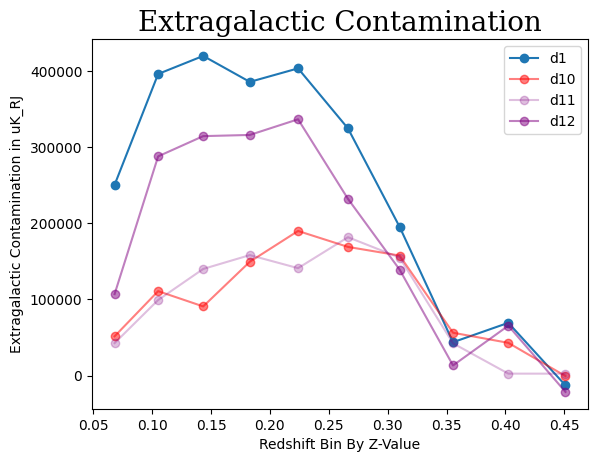

In [17]:
plt.plot(z_bins[:10],corr_data[0][:10], marker='o', label='d1')
plt.plot(z_bins[:10],corr_data[2][:10],marker='o',color='red',alpha=0.5,label='d10')
plt.plot(z_bins[:10],corr_data[3][:10],marker='o',color='purple',alpha=0.25,label='d11')
plt.plot(z_bins[:10],corr_data[4][:10],marker='o',color='purple',alpha=0.5,label='d12')
plt.xlabel('Redshift Bin By Z-Value')
plt.ylabel('Extragalactic Contamination in uK_RJ')
plt.legend()
plt.title('Extragalactic Contamination', fontdict={'fontname': 'serif', 'fontsize' : 20})
plt.show()